# Throughput plotted against SNR

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as ss
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler

### Fixed parameters


In [2]:
# Constants
num_iter = 10000  # Number of Monte Carlo iterations
N = 2  # No of NOMA users
S = 4096  # Sampled length
a1, a2 = 0.8, 0.2  # Power allocations
Pf = 0.1  # False-alarm probability
env_SNRs_dB = np.arange(
    -25, 6, 1
)  # Range of environmental SNR values to iterate through
transmitter_power = 1
τ_T = 0.01  # Ratio of sensing time to total time
Throughputs_without_LR = []
Throughputs_with_LR = []

### Lists to store results


In [3]:
Pds = []  # List to store detection probabilities
TPRs = []  # List to store true positive rates
Throughputs_without_LR = []  # List to store throughputs
Throughputs_with_LR = []  # List to store throughputs

### Monte Carlo simulation


In [4]:
for env_SNR_dB in env_SNRs_dB:
    # Convert SNR from dB to linear scale
    env_SNR_linear = transmitter_power * 10 ** (env_SNR_dB / 10)

    # Noise standard deviation based on environmental SNR
    N0 = np.sqrt(1 / (2 * env_SNR_linear))

    # Threshold for AND joint user decision
    lambda_AND = (np.sqrt(-np.log(Pf) / (N * S))) * (N0**2)

    # Monte Carlo simulation
    total_transmit = 0
    successful_detection = 0
    false_alarm_count = 0

    F = []

    for _ in range(num_iter):
        # Random cyclic delays
        d1, d2 = np.random.randint(1, S, 2)

        # Complex normal channel coefficients
        h1 = np.random.normal(0, np.sqrt(0.5)) + 1j * np.random.normal(0, np.sqrt(0.5))
        h2 = np.random.normal(0, np.sqrt(0.5)) + 1j * np.random.normal(0, np.sqrt(0.5))

        # 50% chance that BS1 will transmit signal
        transmit = np.random.rand() < 0.5

        if transmit:
            total_transmit += 1

            # Generating signals for user 1 and user 2
            x1_n = np.random.randn(S)
            x2_n = np.random.randn(S)

            # Combining signals to produce t1 and t2
            t1_n = a1 * x1_n + a2 * x2_n
            t2_n = a1 * np.roll(x1_n, d1) + a2 * np.roll(x2_n, d2)

            # Rayleigh distributed complex normal noise
            noise_std_dev = N0 * np.sqrt(1 / 2)
            noise = noise_std_dev * (np.random.randn(S) + 1j * np.random.randn(S))

            # Final sent signal
            r_n = h1 * t1_n + h2 * t2_n + noise

            # Cyclic correlation processing
            F_delta1 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d1)))) / S
            F_delta2 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d2)))) / S

            F.append({"F1": F_delta1, "F2": F_delta2, "transmit": 1})

            # Decision
            if F_delta1 > lambda_AND and F_delta2 > lambda_AND:
                successful_detection += 1

        if not transmit:
            # Generating noise only
            noise_std_dev = N0 * np.sqrt(1 / 2)
            noise = noise_std_dev * (np.random.randn(S) + 1j * np.random.randn(S))
            r_n = noise

            # Cyclic correlation processing
            F_delta1 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d1)))) / S
            F_delta2 = np.abs(np.sum(r_n * np.conj(np.roll(r_n, d2)))) / S

            F.append({"F1": F_delta1, "F2": F_delta2, "transmit": 0})

            # Decision
            if F_delta1 > lambda_AND and F_delta2 > lambda_AND:
                false_alarm_count += 1

    # Probability of detection
    Pd = successful_detection / total_transmit if total_transmit > 0 else 0
    Pds.append(Pd)

    # Convert F to DataFrame
    F = pd.DataFrame(F)
    X = F[["F1", "F2"]]
    y = F["transmit"]

    # Normalize the features using StandardScaler
    scaler = StandardScaler()
    X_normalized = scaler.fit_transform(X)

    # Divide the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_normalized, y, test_size=0.2, random_state=42
    )

    # Classifier
    clf = LogisticRegression(random_state=42, max_iter=1000)

    # Train the Classifier
    clf.fit(X_train, y_train)

    # Define the desired FPR
    desired_fpr = 0.1

    # ROC curve plotting
    y_probs = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Create an interpolation function using the FPR and TPR values
    interp_tpr = interp1d(fpr, tpr)

    # Define a new set of FPR values for the interpolated curve
    new_fpr = np.linspace(0, 1, 1000)

    # Use the interpolation function to find the TPR for the new FPR values
    new_tpr = interp_tpr(new_fpr)

    # TPR at desired FPR
    tpr = interp_tpr(desired_fpr)
    TPRs.append(tpr)

In [5]:
for env_SNR_dB in env_SNRs_dB:
    # Convert SNR from dB to linear scale
    env_SNR_linear = transmitter_power * 10 ** (env_SNR_dB / 10)

    # Noise standard deviation based on environmental SNR
    N0 = np.sqrt(1 / (2 * env_SNR_linear))

    Throughput_without_LR = 0
    Throughput_with_LR = 0

    for i in range(num_iter):
        # Complex normal channel coefficients
        h1 = np.random.normal(0, np.sqrt(0.5)) + 1j * np.random.normal(0, np.sqrt(0.5))
        h2 = np.random.normal(0, np.sqrt(0.5)) + 1j * np.random.normal(0, np.sqrt(0.5))

        Rd = np.log(1 + ((a1 * np.power(np.abs(h1), 2)) / (np.power(N0, 2)))) + np.log(
            1
            + (
                (a2 * np.power(np.abs(h2), 2))
                / (a1 * np.power(np.abs(h2), 2) + np.power(N0, 2))
            )
        )

        Throughput_without_LR += (1 - τ_T) * 0.5 * (1 - Pf) * Rd + 0.5 * Rd * Pds[
            env_SNR_dB + 25
        ]
        Throughput_with_LR += (1 - τ_T) * 0.5 * (1 - Pf) * Rd + 0.5 * Rd * TPRs[
            env_SNR_dB + 25
        ]

    Throughput_without_LR = Throughput_without_LR / num_iter
    Throughput_with_LR = Throughput_with_LR / num_iter
    
    Throughputs_without_LR = np.append(Throughputs_without_LR, Throughput_without_LR)
    Throughputs_with_LR = np.append(Throughputs_with_LR, Throughput_with_LR)

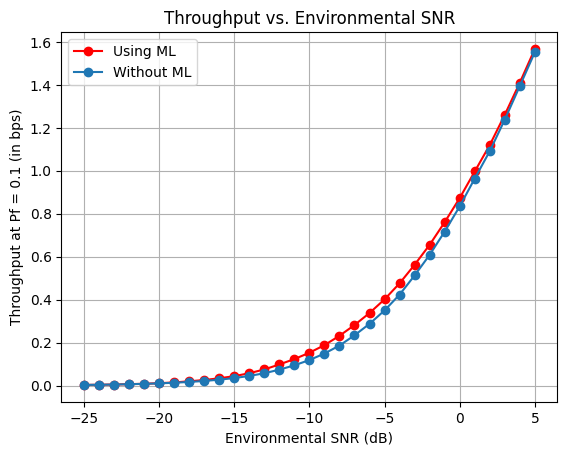

In [6]:
from scipy.signal import savgol_filter

plt.figure()

# Smooth the graph of Pds
Throughputs_with_LR_smooth = savgol_filter(Throughputs_with_LR, window_length=5, polyorder=3)
Throughputs_without_LR_smooth = savgol_filter(Throughputs_without_LR, window_length=5, polyorder=3)

# Plot the smoothed Throughput vs. Environmental SNR
plt.plot(env_SNRs_dB, Throughputs_with_LR_smooth, marker="o", color="red", label="Using ML")
plt.plot(env_SNRs_dB, Throughputs_without_LR_smooth, marker="o", label="Without ML")

plt.title("Throughput vs. Environmental SNR")
plt.xlabel("Environmental SNR (dB)")
plt.ylabel("Throughput at Pf = 0.1 (in bps)")
plt.grid(True)
plt.legend()
plt.show()